# ISPR 2025 - Midterm 3 - Assignament 2 - Gianluca Panzani (550358)

In [86]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms

## Util methods

In [87]:
def get_img(img_dir: str, prefix: str, index: int, postfix: str, mask=False) -> Image:
    zeros = '00' if index < 10 else '0' if index < 100 else ''
    full_path = f'{img_dir}{prefix}{zeros}{index}{postfix}'
    if not mask:
        return Image.open(full_path).convert('RGB')
    return Image.open(full_path).convert('L')

def from_img_to_tensor(img: Image, resize_shape: tuple, mean=None, std=None) -> torch.Tensor:
    if mean is not None and std is not None:
        if not (len(mean) == 3 and len(std) == 3):
            raise ValueError('The image has 3 channles. The parameters "mean" and "std" have to be of length equal to 3.')
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor(), # Scaling
            transforms.Normalize(mean, std) # Normalization
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor() # Scaling
        ])
    return transform(img)
    
def from_mask_to_tensor(img: Image, resize_shape: tuple) -> torch.Tensor:
    transform = transforms.Compose([
        transforms.Resize(resize_shape), # Resize
        transforms.ToTensor(), # Scaling
    ])
    img = transform(img)
    return (img > 0.5).float() # Binarization

def get_mean_and_std(images_dir: str, img_prefix: str, img_postfix: str, resize_shape: tuple):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    i = 0
    while True:
        i += 1
        try:
            image = get_img(img_dir=images_dir, prefix=img_prefix, index=i, postfix=img_postfix, mask=False)
        except:
            break
        img = from_img_to_tensor(img=image, resize_shape=resize_shape)
        mean += img.mean(dim=(1, 2)) # Mean computed on each channel (e.g. with RGB -> [meanR,meanG,meanB])
        std += img.std(dim=(1, 2)) # Std computed on each channel (e.g. with RGB -> [stdR,stdG,stdB])
    mean = (mean / (i-1)).tolist()
    std = (std / (i-1)).tolist()
    return mean, std

## Dataset class definition

In [88]:
class HorseSegmentationDataset(Dataset):
    def __init__(self, images_dir, img_prefix, img_postfix, masks_dir, mask_prefix, mask_postfix, resize_shape=(128,128)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.resize_shape = resize_shape
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.img_postfix = img_postfix
        self.mask_postfix = mask_postfix
        self.length = len(os.listdir(images_dir))
        mean, std = get_mean_and_std(
            images_dir=self.images_dir,
            img_prefix=self.img_prefix,
            img_postfix=self.img_postfix,
            resize_shape=self.resize_shape
        )
        self.mean = mean
        self.std = std

    def __getitem__(self, index):
        img = get_img(self.images_dir, self.img_prefix, index+1, self.img_postfix, mask=False)
        mask = get_img(self.masks_dir, self.mask_prefix, index+1, self.mask_postfix, mask=True)
        img_tensor = from_img_to_tensor(img, self.resize_shape, self.mean, self.std)
        mask_tensor = from_mask_to_tensor(mask, self.resize_shape)
        return img_tensor, mask_tensor
    
    def __len__(self):
        return self.length



# Creation of the dataset object
dataset = HorseSegmentationDataset(
    images_dir='weizmann_horse_db/horse/',
    img_prefix='horse',
    img_postfix='.png',
    masks_dir='weizmann_horse_db/mask/',
    mask_prefix='horse',
    mask_postfix='.png',
    resize_shape=(128,128)
)

In [89]:
class SegmentationCNN(nn.Module):
    def __init__(self,
                 encoder_channels: list[int],
                 decoder_channels: list[int],
                 encoder_kernel_sizes: list[int],
                 decoder_kernel_sizes: list[int],
                 encoder_strides: list[int],
                 decoder_strides: list[int],
                 output_padding: int):
        super(SegmentationCNN, self).__init__()
        # Encoder architecture
        layers = []
        for i in range(len(encoder_channels)-1):
            k = encoder_kernel_sizes[i]
            s = encoder_strides[i]
            layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=k, stride=s, padding=k//2))
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)
        # Decoder architecture
        layers = []
        for i in range(len(decoder_channels)-2):
            k = decoder_kernel_sizes[i]
            s = decoder_strides[i]
            layers.append(nn.ConvTranspose2d(decoder_channels[i], decoder_channels[i+1], kernel_size=k, stride=s, padding=k, output_padding=output_padding))
            layers.append(nn.ReLU())
        layers.append(nn.ConvTranspose2d(decoder_channels[-2], decoder_channels[-1], kernel_size=decoder_kernel_sizes[-1], stride=decoder_strides[-1]))
        layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return x

## Grid search
The best hyperparameters are searched with the Grid search technique.

In [90]:
def get_params_combinations(params: dict) -> list[dict]:
    '''
    Creates and saves into the class instance a list with all the possible combinations of parameters \
    in the dictionary "params".

    Parameters:
    - params: dictionary with the parameters as associations <key:values> (with: key=parameter_name,
    values=possible_values_list).

    Returns:
    A list of dictionaries such that each one represents a combination of parameters (1 combination = 1 dictionary).
    '''
    params_index_dict = {}
    params_combinations = []
    for key in params.keys():
        params_index_dict[key] = 0 # current_index for that key
    while sum([index+1 for _, index in params_index_dict.items()]) != sum(len(val_list) for _, val_list in params.items()):
        params_i = {}
        for key, i in params_index_dict.items():
            params_i[key] = params[key][i]
        params_combinations.append(params_i)
        for key in params_index_dict.keys():
            params_index_dict[key] += 1
            if params_index_dict[key] < len(params[key]):
                break
            params_index_dict[key] = 0
    params_i = {}
    for key, i in params_index_dict.items():
        params_i[key] = params[key][i]
    params_combinations.append(params_i)
    return params_combinations


# Space of the hyperparameters
params_space = {
    'batch_size': [8, 16, 32],
    'learning_rate': [0.0001, 0.001, 0.01],
    'epochs': [10, 30],
    'architecture': [
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,3], 'encoder_strides': [2,2,1],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [3,3,3], 'decoder_strides': [2,2,1],
            'output_padding': 1
        },
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,3], 'encoder_strides': [2,2,2],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [2,2,2], 'decoder_strides': [2,2,2],
            'output_padding': 1
        },
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [5,5,5], 'encoder_strides': [2,2,2],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [4,4,4], 'decoder_strides': [2,2,2],
            'output_padding': 1
        }
    ]
}

## Training and Testing methods

In [91]:
def show_plot(tr_losses: list, vl_losses: list):
    plt.plot(tr_losses, label='Training Loss')
    plt.plot(vl_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss functions')
    plt.show()


def train(model: nn.Module, tr_dataloader: DataLoader, vl_dataloader: DataLoader, optimizer, criterion, device, epochs, verbose=1):
    model.to(device)
    model.train()

    # Initializations
    threshold = 0.00001
    prev_vl_loss = 1
    tr_losses = []
    vl_losses = []

    # Iterate on the epochs
    for epoch in range(epochs):
        total_loss = 0.0

        # Iterate on the batches (of the training set)
        for imgs, masks in tr_dataloader:
            imgs = imgs.to(device)          # Move images' tensors on GPU or CPU
            masks = masks.to(device)        # Move masks' tensors on GPU or CPU

            preds = model(imgs)             # Compute the predictions
            loss = criterion(preds, masks)  # Compute the loss
            optimizer.zero_grad()           # Reset the gradients
            loss.backward()                 # Perform backpropagation
            optimizer.step()                # Update model's parameters (based on gradients)

            total_loss += loss.item()       # Update total loss with the average loss on this batch

        # Compute the average loss on the epoch
        tr_avg_loss = total_loss / len(tr_dataloader)
        tr_losses.append(tr_avg_loss)

        # Start validation phase
        model.eval()

        # Disable the update of the gradients
        with torch.no_grad():
            total_loss = 0.0

            # Iterations on the batches (of the validation set)
            for imgs, masks in vl_dataloader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                preds = model(imgs)
                loss = criterion(preds, masks)

                total_loss += loss.item()

        vl_avg_loss = total_loss / len(vl_dataloader)
        vl_losses.append(vl_avg_loss)

        # Early stopping
        if abs(prev_vl_loss - vl_avg_loss) < threshold:
            patience += 1
        else:
            patience = 0
        if patience > 5:
            break
        prev_vl_loss = vl_avg_loss

        # Print of the epoch result
        if verbose > 0:
            print(f'Epoch {epoch+1}/{epochs}: TR_loss={tr_avg_loss:.6f} - VL_loss={vl_avg_loss:.6f}')
    
    return tr_losses, vl_losses


def test():
    pass

## Model selection

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.5103 - VL_loss=0.3631
Epoch 2/10: TR_loss=0.2377 - VL_loss=0.1093
Epoch 3/10: TR_loss=0.0735 - VL_loss=0.0406
Epoch 4/10: TR_loss=0.0328 - VL_loss=0.0225
Epoch 5/10: TR_loss=0.0194 - VL_loss=0.0146
Epoch 6/10: TR_loss=0.0130 - VL_loss=0.0103
Epoch 7/10: TR_loss=0.0095 - VL_loss=0.0078
Epoch 8/10: TR_loss=0.0073 - VL_loss=0.0061
Epoch 9/10: TR_loss=0.0058 - VL_loss=0.0049
Epoch 10/10: TR_loss=0.0047 - VL_loss=0.0040


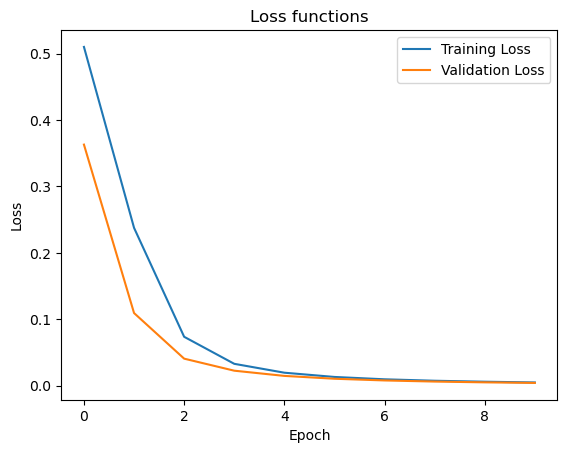

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.6102 - VL_loss=0.5508
Epoch 2/10: TR_loss=0.4969 - VL_loss=0.4224
Epoch 3/10: TR_loss=0.3616 - VL_loss=0.2706
Epoch 4/10: TR_loss=0.2166 - VL_loss=0.1471
Epoch 5/10: TR_loss=0.1215 - VL_loss=0.0815
Epoch 6/10: TR_loss=0.0728 - VL_loss=0.0502
Epoch 7/10: TR_loss=0.0465 - VL_loss=0.0342
Epoch 8/10: TR_loss=0.0337 - VL_loss=0.0253
Epoch 9/10: TR_loss=0.0257 - VL_loss=0.0196
Epoch 10/10: TR_loss=0.0200 - VL_loss=0.0157


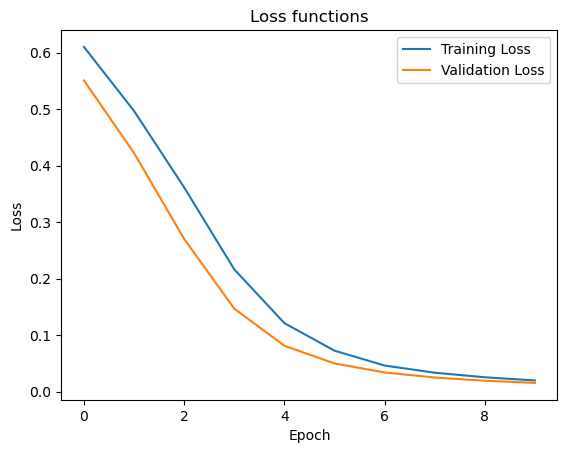

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.6655 - VL_loss=0.6124
Epoch 2/10: TR_loss=0.5829 - VL_loss=0.5267
Epoch 3/10: TR_loss=0.4978 - VL_loss=0.4373
Epoch 4/10: TR_loss=0.4158 - VL_loss=0.3437
Epoch 5/10: TR_loss=0.3195 - VL_loss=0.2537
Epoch 6/10: TR_loss=0.2301 - VL_loss=0.1768
Epoch 7/10: TR_loss=0.1635 - VL_loss=0.1206
Epoch 8/10: TR_loss=0.1123 - VL_loss=0.0832
Epoch 9/10: TR_loss=0.0800 - VL_loss=0.0597
Epoch 10/10: TR_loss=0.0614 - VL_loss=0.0445


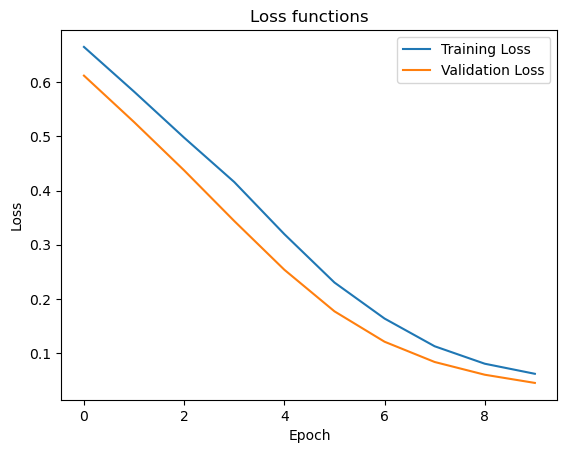

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.1703 - VL_loss=0.0010
Epoch 2/10: TR_loss=0.0006 - VL_loss=0.0003
Epoch 3/10: TR_loss=0.0003 - VL_loss=0.0002
Epoch 4/10: TR_loss=0.0002 - VL_loss=0.0001
Epoch 5/10: TR_loss=0.0002 - VL_loss=0.0001
Epoch 6/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 7/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 8/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 9/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 10/10: TR_loss=0.0001 - VL_loss=0.0000


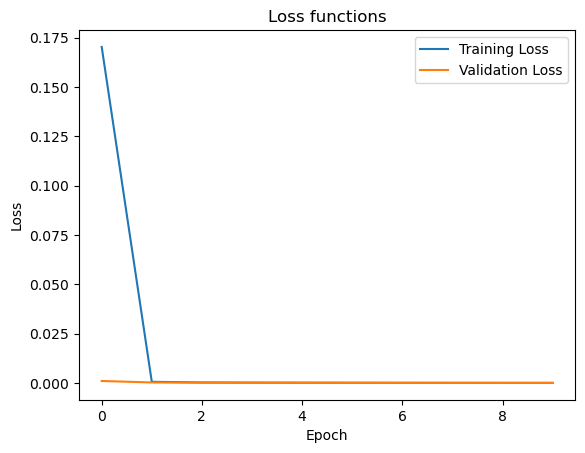

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.1952 - VL_loss=0.0066
Epoch 2/10: TR_loss=0.0028 - VL_loss=0.0006
Epoch 3/10: TR_loss=0.0005 - VL_loss=0.0003
Epoch 4/10: TR_loss=0.0003 - VL_loss=0.0002
Epoch 5/10: TR_loss=0.0002 - VL_loss=0.0001
Epoch 6/10: TR_loss=0.0002 - VL_loss=0.0001
Epoch 7/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 8/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 9/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 10/10: TR_loss=0.0001 - VL_loss=0.0000


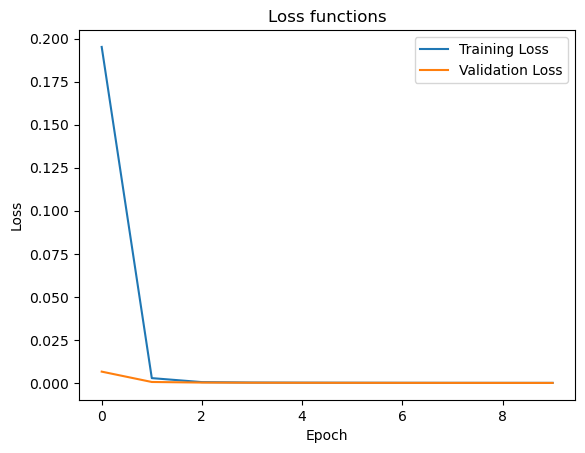

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.3106 - VL_loss=0.0355
Epoch 2/10: TR_loss=0.0146 - VL_loss=0.0029
Epoch 3/10: TR_loss=0.0019 - VL_loss=0.0008
Epoch 4/10: TR_loss=0.0007 - VL_loss=0.0004
Epoch 5/10: TR_loss=0.0004 - VL_loss=0.0003
Epoch 6/10: TR_loss=0.0003 - VL_loss=0.0002
Epoch 7/10: TR_loss=0.0002 - VL_loss=0.0002
Epoch 8/10: TR_loss=0.0002 - VL_loss=0.0002
Epoch 9/10: TR_loss=0.0002 - VL_loss=0.0002
Epoch 10/10: TR_loss=0.0002 - VL_loss=0.0001


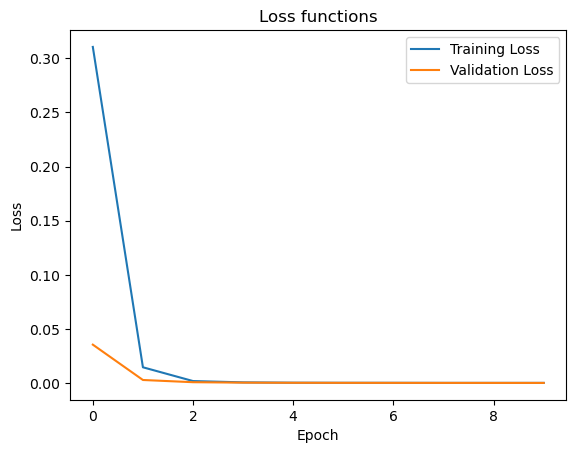

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.01, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.0303 - VL_loss=0.0000
Epoch 2/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/10: TR_loss=0.0000 - VL_loss=0.0000


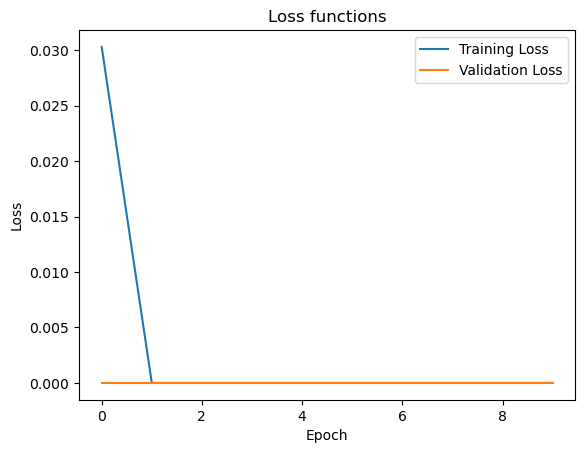

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.01, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.0572 - VL_loss=0.0000
Epoch 2/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/10: TR_loss=0.0000 - VL_loss=0.0000


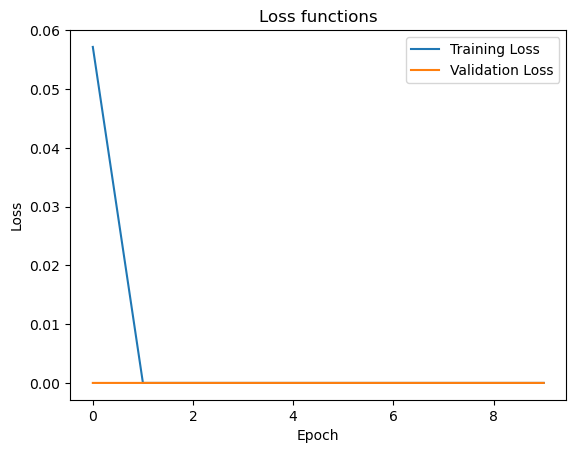

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.01, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.0985 - VL_loss=0.0000
Epoch 2/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/10: TR_loss=0.0000 - VL_loss=0.0000


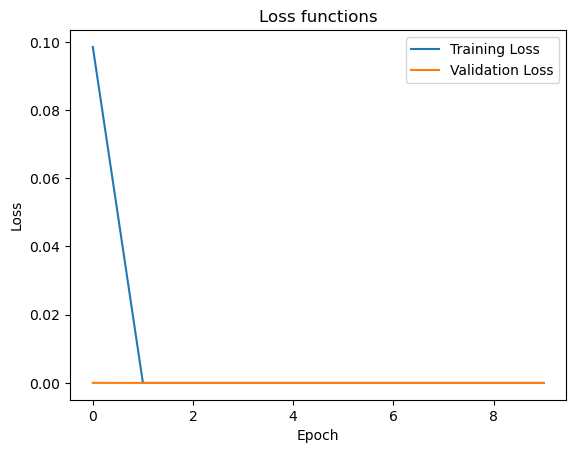

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.7516 - VL_loss=0.5848
Epoch 2/30: TR_loss=0.3937 - VL_loss=0.1855
Epoch 3/30: TR_loss=0.1090 - VL_loss=0.0475
Epoch 4/30: TR_loss=0.0354 - VL_loss=0.0215
Epoch 5/30: TR_loss=0.0188 - VL_loss=0.0129
Epoch 6/30: TR_loss=0.0122 - VL_loss=0.0088
Epoch 7/30: TR_loss=0.0088 - VL_loss=0.0065
Epoch 8/30: TR_loss=0.0068 - VL_loss=0.0050
Epoch 9/30: TR_loss=0.0054 - VL_loss=0.0040
Epoch 10/30: TR_loss=0.0043 - VL_loss=0.0033
Epoch 11/30: TR_loss=0.0036 - VL_loss=0.0027
Epoch 12/30: TR_loss=0.0030 - VL_loss=0.0022
Epoch 13/30: TR_loss=0.0025 - VL_loss=0.0019
Epoch 14/30: TR_loss=0.0021 - VL_loss=0.0015
Epoch 15/30: TR_loss=0.0017 - VL_loss=0.0012
Epoch 16/30: TR_loss=0.00

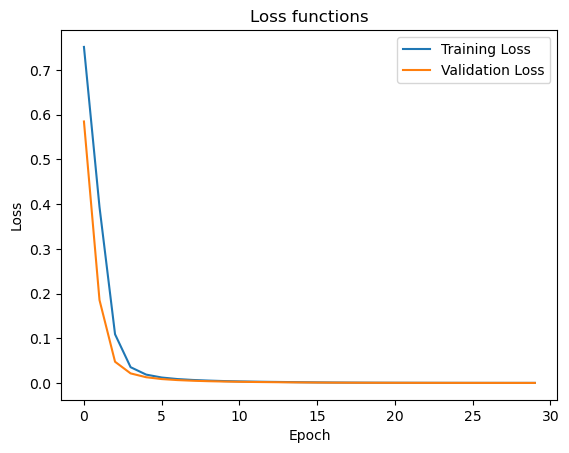

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.4458 - VL_loss=0.3463
Epoch 2/30: TR_loss=0.2834 - VL_loss=0.1854
Epoch 3/30: TR_loss=0.1454 - VL_loss=0.0827
Epoch 4/30: TR_loss=0.0676 - VL_loss=0.0398
Epoch 5/30: TR_loss=0.0350 - VL_loss=0.0232
Epoch 6/30: TR_loss=0.0220 - VL_loss=0.0160
Epoch 7/30: TR_loss=0.0159 - VL_loss=0.0122
Epoch 8/30: TR_loss=0.0123 - VL_loss=0.0097
Epoch 9/30: TR_loss=0.0098 - VL_loss=0.0080
Epoch 10/30: TR_loss=0.0085 - VL_loss=0.0068
Epoch 11/30: TR_loss=0.0072 - VL_loss=0.0058
Epoch 12/30: TR_loss=0.0060 - VL_loss=0.0050
Epoch 13/30: TR_loss=0.0054 - VL_loss=0.0044
Epoch 14/30: TR_loss=0.0048 - VL_loss=0.0039
Epoch 15/30: TR_loss=0.0043 - VL_loss=0.0035
Epoch 16/30: TR_loss=0.0

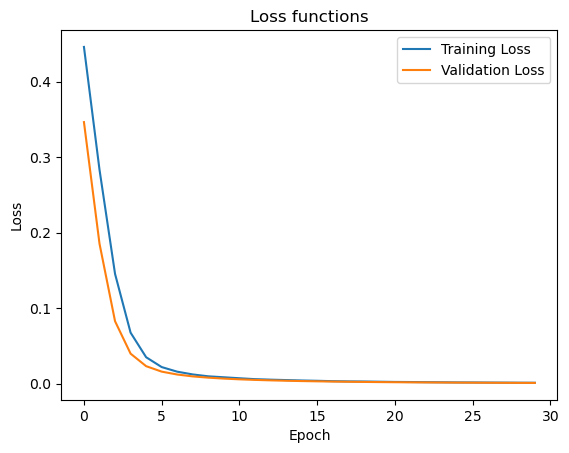

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.6131 - VL_loss=0.5561
Epoch 2/30: TR_loss=0.5135 - VL_loss=0.4478
Epoch 3/30: TR_loss=0.4090 - VL_loss=0.3331
Epoch 4/30: TR_loss=0.2907 - VL_loss=0.2276
Epoch 5/30: TR_loss=0.1992 - VL_loss=0.1449
Epoch 6/30: TR_loss=0.1267 - VL_loss=0.0905
Epoch 7/30: TR_loss=0.0806 - VL_loss=0.0580
Epoch 8/30: TR_loss=0.0528 - VL_loss=0.0393
Epoch 9/30: TR_loss=0.0387 - VL_loss=0.0285
Epoch 10/30: TR_loss=0.0286 - VL_loss=0.0218
Epoch 11/30: TR_loss=0.0222 - VL_loss=0.0175
Epoch 12/30: TR_loss=0.0194 - VL_loss=0.0145
Epoch 13/30: TR_loss=0.0159 - VL_loss=0.0123
Epoch 14/30: TR_loss=0.0134 - VL_loss=0.0107
Epoch 15/30: TR_loss=0.0114 - VL_loss=0.0094
Epoch 16/30: TR_loss=0.0

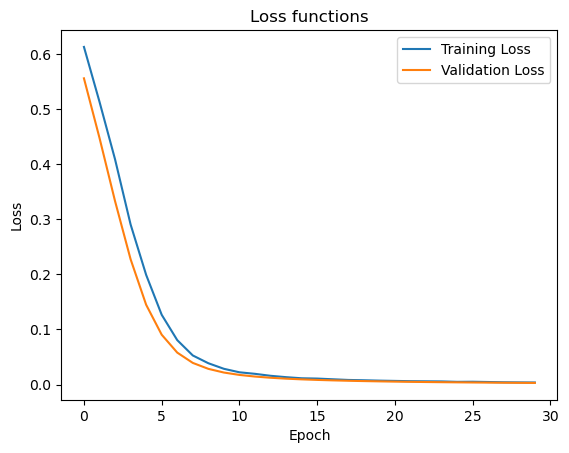

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.0734 - VL_loss=0.0010
Epoch 2/30: TR_loss=0.0005 - VL_loss=0.0003
Epoch 3/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 4/30: TR_loss=0.0001 - VL_loss=0.0001
Epoch 5/30: TR_loss=0.0001 - VL_loss=0.0001
Epoch 6/30: TR_loss=0.0001 - VL_loss=0.0001
Epoch 7/30: TR_loss=0.0001 - VL_loss=0.0000
Epoch 8/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 11/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 12/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 13/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 14/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 15/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 16/30: TR_loss=0.000

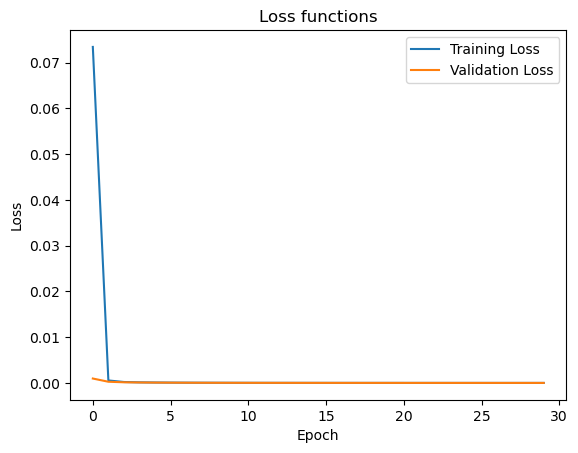

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.2470 - VL_loss=0.0087
Epoch 2/30: TR_loss=0.0041 - VL_loss=0.0012
Epoch 3/30: TR_loss=0.0011 - VL_loss=0.0006
Epoch 4/30: TR_loss=0.0007 - VL_loss=0.0004
Epoch 5/30: TR_loss=0.0005 - VL_loss=0.0004
Epoch 6/30: TR_loss=0.0004 - VL_loss=0.0003
Epoch 7/30: TR_loss=0.0004 - VL_loss=0.0002
Epoch 8/30: TR_loss=0.0003 - VL_loss=0.0002
Epoch 9/30: TR_loss=0.0003 - VL_loss=0.0002
Epoch 10/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 11/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 12/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 13/30: TR_loss=0.0001 - VL_loss=0.0001
Epoch 14/30: TR_loss=0.0001 - VL_loss=0.0001
Epoch 15/30: TR_loss=0.0001 - VL_loss=0.0001
Epoch 16/30: TR_loss=0.00

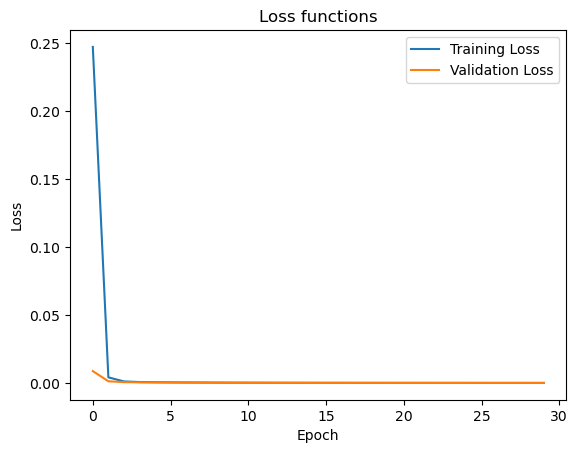

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.5388 - VL_loss=0.1382
Epoch 2/30: TR_loss=0.0526 - VL_loss=0.0053
Epoch 3/30: TR_loss=0.0029 - VL_loss=0.0009
Epoch 4/30: TR_loss=0.0007 - VL_loss=0.0004
Epoch 5/30: TR_loss=0.0003 - VL_loss=0.0002
Epoch 6/30: TR_loss=0.0002 - VL_loss=0.0002
Epoch 7/30: TR_loss=0.0002 - VL_loss=0.0002
Epoch 8/30: TR_loss=0.0002 - VL_loss=0.0002
Epoch 9/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 10/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 11/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 12/30: TR_loss=0.0001 - VL_loss=0.0001
Epoch 13/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 14/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 15/30: TR_loss=0.0001 - VL_loss=0.0001
Epoch 16/30: TR_loss=0.00

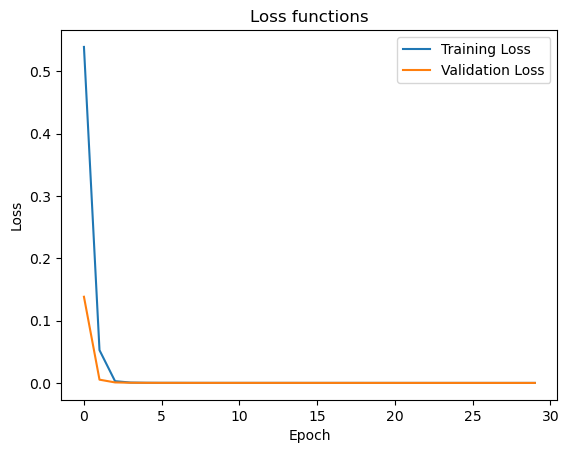

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.01, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.0389 - VL_loss=0.0000
Epoch 2/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 11/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 12/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 13/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 14/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 15/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 16/30: TR_loss=0.0000

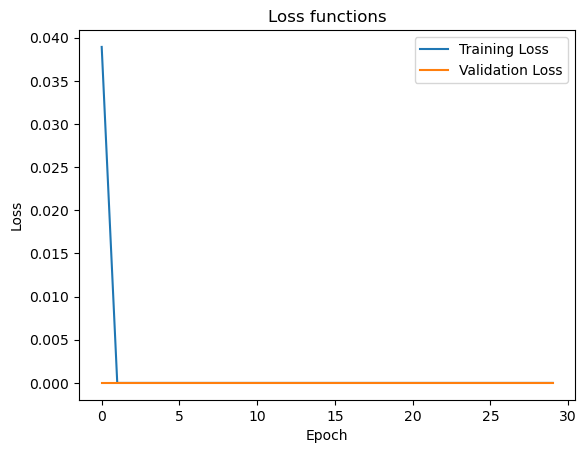

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.01, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.0466 - VL_loss=0.0000
Epoch 2/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 11/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 12/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 13/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 14/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 15/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 16/30: TR_loss=0.000

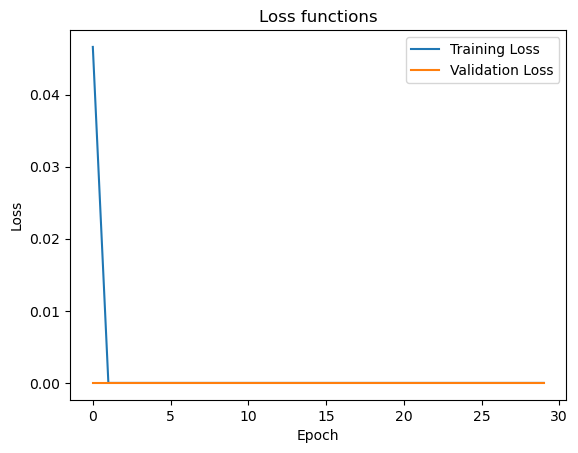

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.01, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.0736 - VL_loss=0.0000
Epoch 2/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 11/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 12/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 13/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 14/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 15/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 16/30: TR_loss=0.000

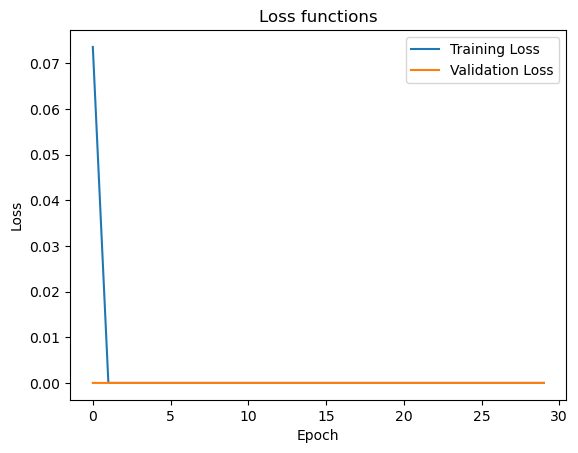

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.5283 - VL_loss=0.4823
Epoch 2/10: TR_loss=0.4270 - VL_loss=0.3450
Epoch 3/10: TR_loss=0.2811 - VL_loss=0.1988
Epoch 4/10: TR_loss=0.1629 - VL_loss=0.1114
Epoch 5/10: TR_loss=0.0964 - VL_loss=0.0671
Epoch 6/10: TR_loss=0.0609 - VL_loss=0.0436
Epoch 7/10: TR_loss=0.0410 - VL_loss=0.0302
Epoch 8/10: TR_loss=0.0292 - VL_loss=0.0223
Epoch 9/10: TR_loss=0.0218 - VL_loss=0.0170
Epoch 10/10: TR_loss=0.0169 - VL_loss=0.0134


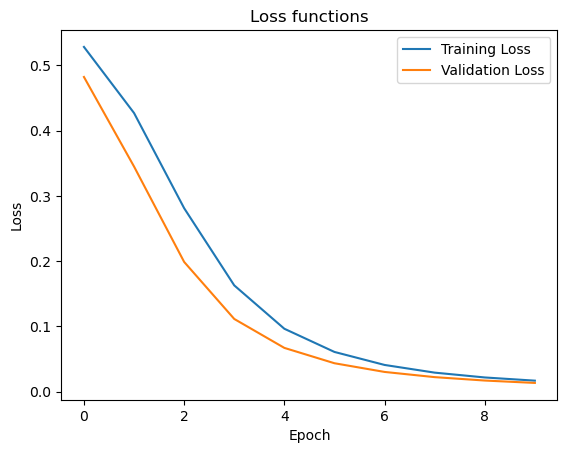

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.6443 - VL_loss=0.6259
Epoch 2/10: TR_loss=0.6121 - VL_loss=0.5820
Epoch 3/10: TR_loss=0.5625 - VL_loss=0.5150
Epoch 4/10: TR_loss=0.4912 - VL_loss=0.4249
Epoch 5/10: TR_loss=0.3984 - VL_loss=0.3229
Epoch 6/10: TR_loss=0.3009 - VL_loss=0.2306
Epoch 7/10: TR_loss=0.2169 - VL_loss=0.1622
Epoch 8/10: TR_loss=0.1573 - VL_loss=0.1164
Epoch 9/10: TR_loss=0.1159 - VL_loss=0.0862
Epoch 10/10: TR_loss=0.0859 - VL_loss=0.0661


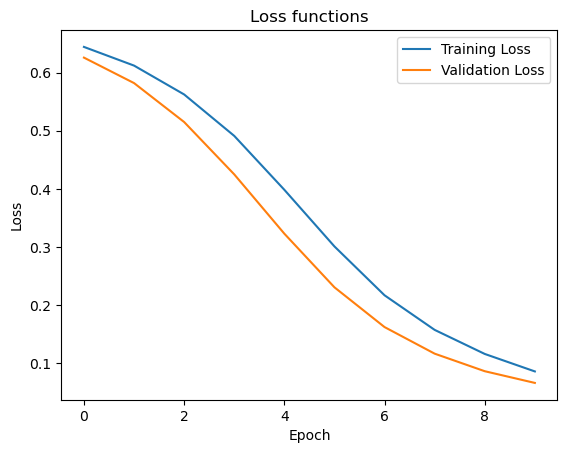

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.6152 - VL_loss=0.6044
Epoch 2/10: TR_loss=0.5981 - VL_loss=0.5864
Epoch 3/10: TR_loss=0.5800 - VL_loss=0.5672
Epoch 4/10: TR_loss=0.5612 - VL_loss=0.5451
Epoch 5/10: TR_loss=0.5382 - VL_loss=0.5192
Epoch 6/10: TR_loss=0.5117 - VL_loss=0.4896
Epoch 7/10: TR_loss=0.4814 - VL_loss=0.4563
Epoch 8/10: TR_loss=0.4495 - VL_loss=0.4190
Epoch 9/10: TR_loss=0.4093 - VL_loss=0.3780
Epoch 10/10: TR_loss=0.3699 - VL_loss=0.3346


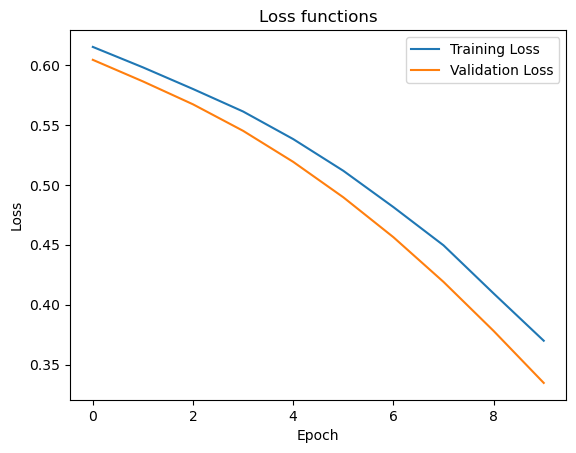

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.1606 - VL_loss=0.0027
Epoch 2/10: TR_loss=0.0011 - VL_loss=0.0004
Epoch 3/10: TR_loss=0.0004 - VL_loss=0.0003
Epoch 4/10: TR_loss=0.0003 - VL_loss=0.0002
Epoch 5/10: TR_loss=0.0002 - VL_loss=0.0002
Epoch 6/10: TR_loss=0.0002 - VL_loss=0.0001
Epoch 7/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 8/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 9/10: TR_loss=0.0001 - VL_loss=0.0001
Epoch 10/10: TR_loss=0.0001 - VL_loss=0.0001


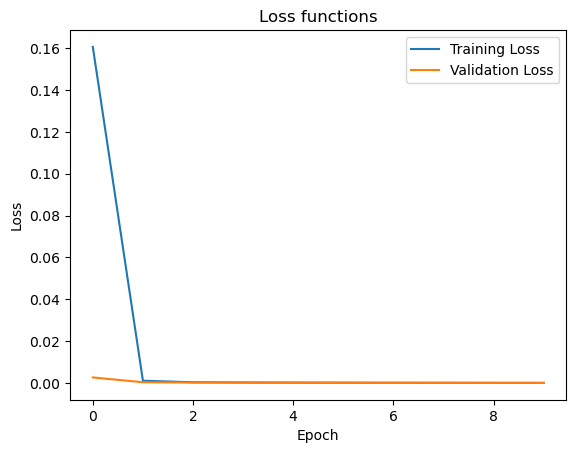

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.5740 - VL_loss=0.1905
Epoch 2/10: TR_loss=0.0663 - VL_loss=0.0083
Epoch 3/10: TR_loss=0.0043 - VL_loss=0.0016
Epoch 4/10: TR_loss=0.0013 - VL_loss=0.0008
Epoch 5/10: TR_loss=0.0008 - VL_loss=0.0006
Epoch 6/10: TR_loss=0.0007 - VL_loss=0.0005
Epoch 7/10: TR_loss=0.0005 - VL_loss=0.0004
Epoch 8/10: TR_loss=0.0005 - VL_loss=0.0004
Epoch 9/10: TR_loss=0.0005 - VL_loss=0.0003
Epoch 10/10: TR_loss=0.0004 - VL_loss=0.0003


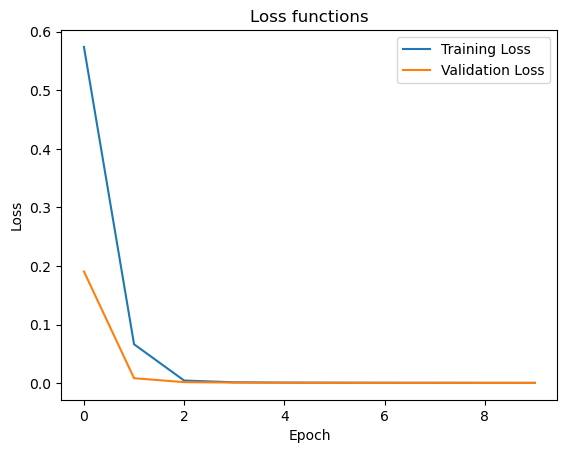

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.6254 - VL_loss=0.4665
Epoch 2/10: TR_loss=0.3336 - VL_loss=0.1622
Epoch 3/10: TR_loss=0.0953 - VL_loss=0.0304
Epoch 4/10: TR_loss=0.0205 - VL_loss=0.0080
Epoch 5/10: TR_loss=0.0063 - VL_loss=0.0033
Epoch 6/10: TR_loss=0.0031 - VL_loss=0.0018
Epoch 7/10: TR_loss=0.0018 - VL_loss=0.0012
Epoch 8/10: TR_loss=0.0013 - VL_loss=0.0010
Epoch 9/10: TR_loss=0.0010 - VL_loss=0.0008
Epoch 10/10: TR_loss=0.0009 - VL_loss=0.0007


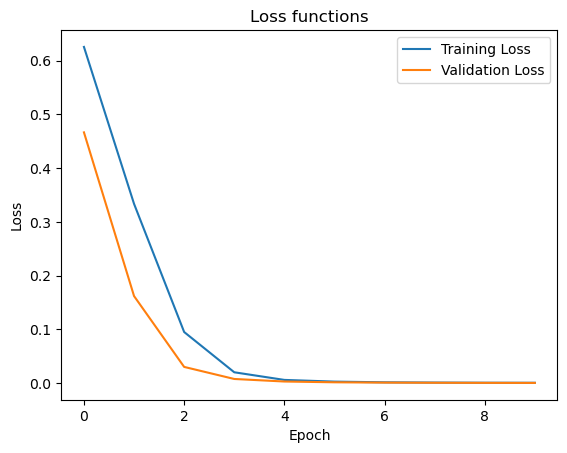

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.01, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.0449 - VL_loss=0.0000
Epoch 2/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/10: TR_loss=0.0000 - VL_loss=0.0000


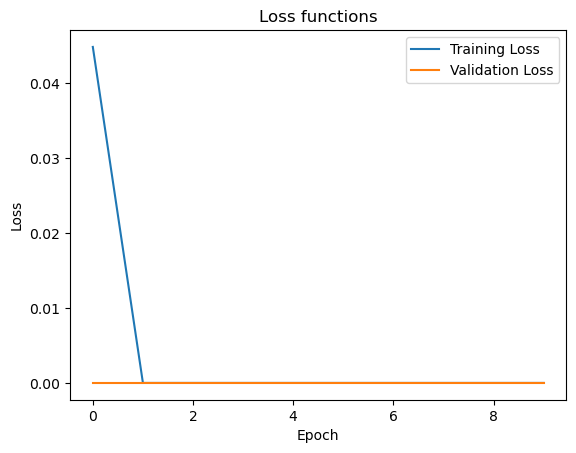

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.01, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.0833 - VL_loss=0.0000
Epoch 2/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/10: TR_loss=0.0000 - VL_loss=0.0000


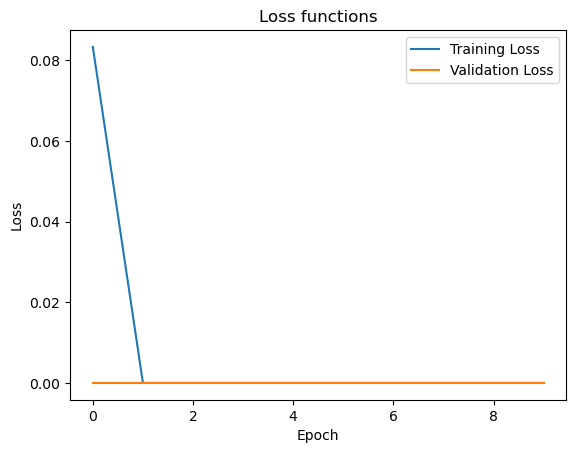

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.01, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.1269 - VL_loss=0.0000
Epoch 2/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/10: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/10: TR_loss=0.0000 - VL_loss=0.0000


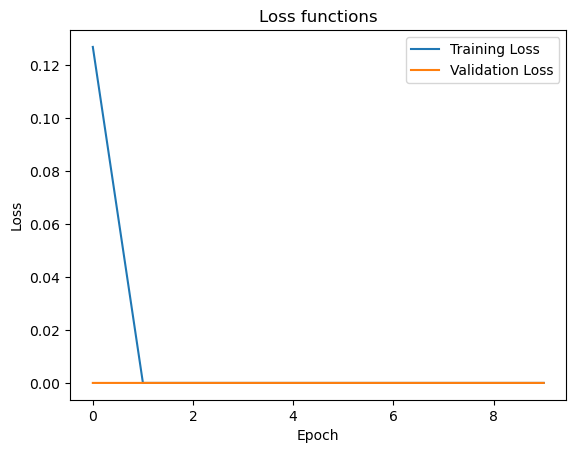

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.8161 - VL_loss=0.7748
Epoch 2/30: TR_loss=0.7264 - VL_loss=0.6431
Epoch 3/30: TR_loss=0.5615 - VL_loss=0.4322
Epoch 4/30: TR_loss=0.3570 - VL_loss=0.2467
Epoch 5/30: TR_loss=0.2051 - VL_loss=0.1382
Epoch 6/30: TR_loss=0.1223 - VL_loss=0.0860
Epoch 7/30: TR_loss=0.0802 - VL_loss=0.0588
Epoch 8/30: TR_loss=0.0565 - VL_loss=0.0422
Epoch 9/30: TR_loss=0.0409 - VL_loss=0.0312
Epoch 10/30: TR_loss=0.0303 - VL_loss=0.0236
Epoch 11/30: TR_loss=0.0230 - VL_loss=0.0180
Epoch 12/30: TR_loss=0.0178 - VL_loss=0.0141
Epoch 13/30: TR_loss=0.0139 - VL_loss=0.0112
Epoch 14/30: TR_loss=0.0113 - VL_loss=0.0092
Epoch 15/30: TR_loss=0.0092 - VL_loss=0.0075
Epoch 16/30: TR_loss=0.00

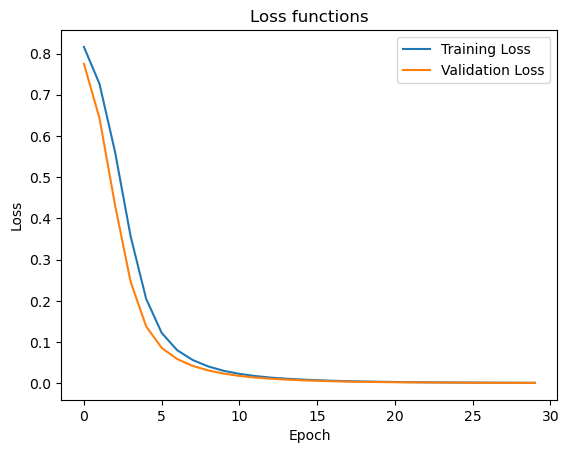

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.7144 - VL_loss=0.6959
Epoch 2/30: TR_loss=0.6767 - VL_loss=0.6548
Epoch 3/30: TR_loss=0.6302 - VL_loss=0.5981
Epoch 4/30: TR_loss=0.5637 - VL_loss=0.5207
Epoch 5/30: TR_loss=0.4826 - VL_loss=0.4302
Epoch 6/30: TR_loss=0.3930 - VL_loss=0.3385
Epoch 7/30: TR_loss=0.3049 - VL_loss=0.2573
Epoch 8/30: TR_loss=0.2309 - VL_loss=0.1915
Epoch 9/30: TR_loss=0.1735 - VL_loss=0.1430
Epoch 10/30: TR_loss=0.1326 - VL_loss=0.1093
Epoch 11/30: TR_loss=0.1029 - VL_loss=0.0856
Epoch 12/30: TR_loss=0.0837 - VL_loss=0.0687
Epoch 13/30: TR_loss=0.0670 - VL_loss=0.0562
Epoch 14/30: TR_loss=0.0559 - VL_loss=0.0468
Epoch 15/30: TR_loss=0.0477 - VL_loss=0.0397
Epoch 16/30: TR_loss=0.0

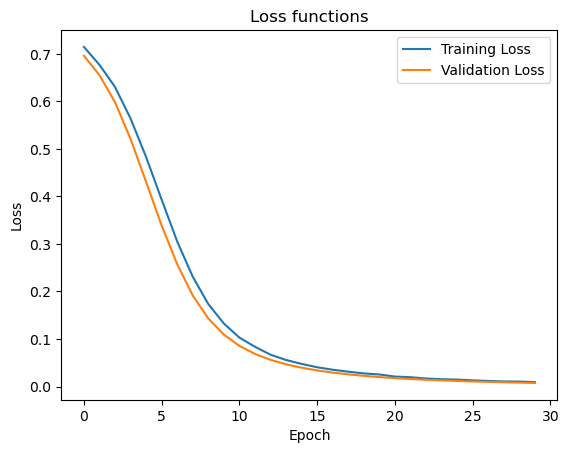

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.9322 - VL_loss=0.9204
Epoch 2/30: TR_loss=0.9113 - VL_loss=0.8983
Epoch 3/30: TR_loss=0.8897 - VL_loss=0.8735
Epoch 4/30: TR_loss=0.8646 - VL_loss=0.8440
Epoch 5/30: TR_loss=0.8341 - VL_loss=0.8079
Epoch 6/30: TR_loss=0.7950 - VL_loss=0.7637
Epoch 7/30: TR_loss=0.7486 - VL_loss=0.7112
Epoch 8/30: TR_loss=0.6999 - VL_loss=0.6516
Epoch 9/30: TR_loss=0.6354 - VL_loss=0.5872
Epoch 10/30: TR_loss=0.5718 - VL_loss=0.5200
Epoch 11/30: TR_loss=0.5050 - VL_loss=0.4536
Epoch 12/30: TR_loss=0.4393 - VL_loss=0.3903
Epoch 13/30: TR_loss=0.3755 - VL_loss=0.3309
Epoch 14/30: TR_loss=0.3182 - VL_loss=0.2766
Epoch 15/30: TR_loss=0.2713 - VL_loss=0.2291
Epoch 16/30: TR_loss=0.2

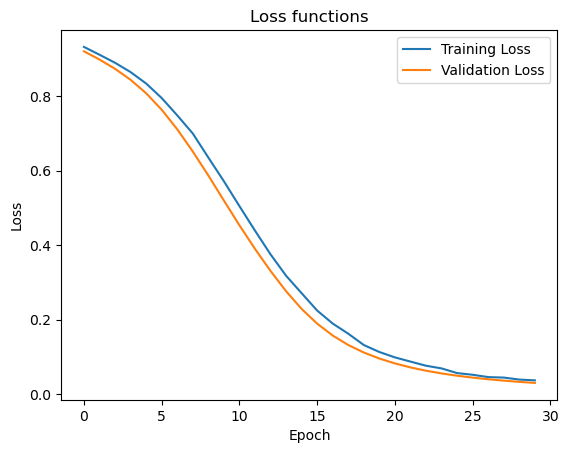

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.2815 - VL_loss=0.0171
Epoch 2/30: TR_loss=0.0056 - VL_loss=0.0013
Epoch 3/30: TR_loss=0.0009 - VL_loss=0.0004
Epoch 4/30: TR_loss=0.0003 - VL_loss=0.0002
Epoch 5/30: TR_loss=0.0002 - VL_loss=0.0001
Epoch 6/30: TR_loss=0.0001 - VL_loss=0.0001
Epoch 7/30: TR_loss=0.0001 - VL_loss=0.0000
Epoch 8/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 11/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 12/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 13/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 14/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 15/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 16/30: TR_loss=0.000

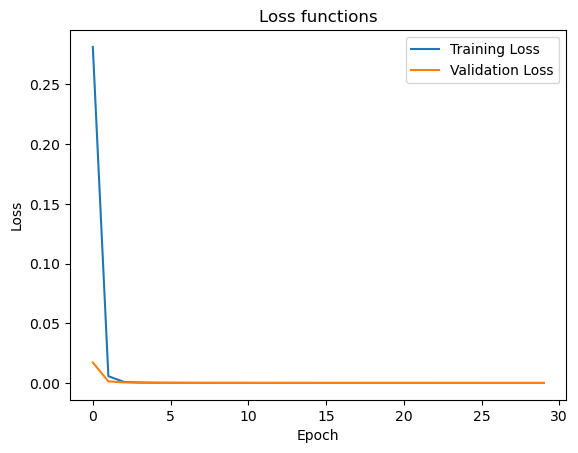

Hyperparameters: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.8271 - VL_loss=0.5879
Epoch 2/30: TR_loss=0.4198 - VL_loss=0.2563
Epoch 3/30: TR_loss=0.1475 - VL_loss=0.0318
Epoch 4/30: TR_loss=0.0203 - VL_loss=0.0077
Epoch 5/30: TR_loss=0.0055 - VL_loss=0.0033
Epoch 6/30: TR_loss=0.0030 - VL_loss=0.0022
Epoch 7/30: TR_loss=0.0021 - VL_loss=0.0016
Epoch 8/30: TR_loss=0.0017 - VL_loss=0.0013
Epoch 9/30: TR_loss=0.0014 - VL_loss=0.0011
Epoch 10/30: TR_loss=0.0011 - VL_loss=0.0009
Epoch 11/30: TR_loss=0.0010 - VL_loss=0.0008
Epoch 12/30: TR_loss=0.0008 - VL_loss=0.0007
Epoch 13/30: TR_loss=0.0007 - VL_loss=0.0006
Epoch 14/30: TR_loss=0.0007 - VL_loss=0.0005
Epoch 15/30: TR_loss=0.0006 - VL_loss=0.0004
Epoch 16/30: TR_loss=0.00

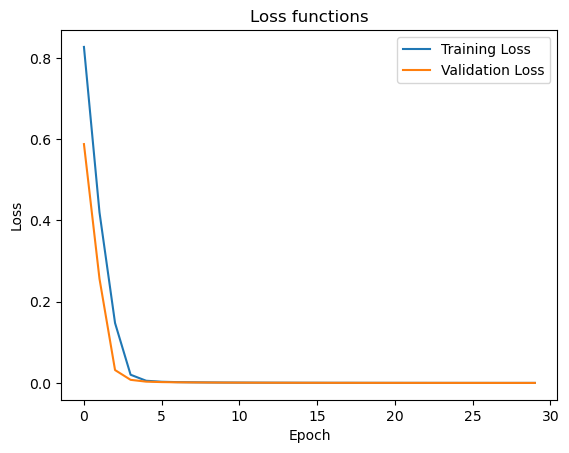

Hyperparameters: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.7535 - VL_loss=0.6386
Epoch 2/30: TR_loss=0.5058 - VL_loss=0.3176
Epoch 3/30: TR_loss=0.2110 - VL_loss=0.0952
Epoch 4/30: TR_loss=0.0603 - VL_loss=0.0267
Epoch 5/30: TR_loss=0.0181 - VL_loss=0.0102
Epoch 6/30: TR_loss=0.0079 - VL_loss=0.0052
Epoch 7/30: TR_loss=0.0047 - VL_loss=0.0034
Epoch 8/30: TR_loss=0.0031 - VL_loss=0.0024
Epoch 9/30: TR_loss=0.0023 - VL_loss=0.0019
Epoch 10/30: TR_loss=0.0018 - VL_loss=0.0016
Epoch 11/30: TR_loss=0.0019 - VL_loss=0.0014
Epoch 12/30: TR_loss=0.0016 - VL_loss=0.0012
Epoch 13/30: TR_loss=0.0012 - VL_loss=0.0010
Epoch 14/30: TR_loss=0.0011 - VL_loss=0.0009
Epoch 15/30: TR_loss=0.0010 - VL_loss=0.0008
Epoch 16/30: TR_loss=0.00

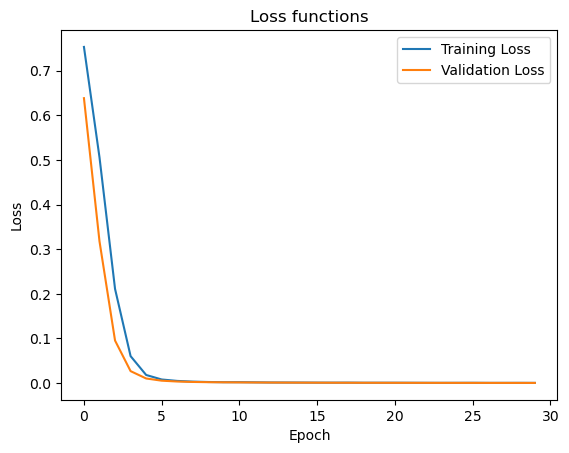

Hyperparameters: {'batch_size': 8, 'learning_rate': 0.01, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.0366 - VL_loss=0.0000
Epoch 2/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 3/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 4/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 5/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 6/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 7/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 8/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 9/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 10/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 11/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 12/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 13/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 14/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 15/30: TR_loss=0.0000 - VL_loss=0.0000
Epoch 16/30: TR_loss=0.0000

KeyboardInterrupt: 

In [92]:
# Iterates on each parameters combination obtained from the parameters space
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.70,0.15,0.15])
params_list = get_params_combinations(params_space)
for i, params in enumerate(params_list):
    print(f'Hyperparameters [{i+1}/{len(params_list)}]: {params}')

    # Datasets initializations
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    # Create the model
    model = SegmentationCNN(**params['architecture'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = torch.nn.BCELoss()

    # Training phase
    tr_losses, vl_losses = train(
        model,
        tr_dataloader=train_loader,
        vl_dataloader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        epochs=params['epochs']
    )

    # Shows the Loss plots
    show_plot(tr_losses, vl_losses)

    # Testing phase
    